In [17]:
from collections import Counter
import json
import os
import os.path as path
import random
import re
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import string

import fasttext
import spacy
from nltk.corpus import stopwords

In [18]:
# directories
data_dir = "../data"
original_dir = path.join(data_dir, "original")

## Language detection

In [6]:
# combine english texts from both groups into single file
outpath = path.join(original_dir, "english-combined.jsonl")

if not path.exists(outpath):
    # prepare pretrained language detector
    language_detector = fasttext.load_model("../models/fasttext-lid.176.bin")

    # load data and label with language
    all_texts = {'other': [], 'sustainability': []}
    for group in all_texts.keys():
        group_dir = path.join(original_dir, group)
        filenames = [_ for _ in os.listdir(group_dir) if _.endswith(".txt")]

        group_texts = []
        languages = set()
        for filename in tqdm(filenames):
            filepath = path.join(group_dir, filename)
            with open(filepath, 'r') as f:
                text = f.read()
                text = text.replace("\n", " ")
                lang = language_detector.predict(text)

                group_texts.append({
                    'filepath': filepath,
                    'text': text,
                    'language': lang[0][0],
                    'probability': lang[1][0] 
                })
                languages.add(lang[0][0])

        all_texts[group] = group_texts

    for group, texts in all_texts.items():
        print(f"\ngroup: {group}")
        for lang in languages:
            print(f"- {lang}: {sum([x['language'] == lang for x in texts])}")

    # export english texts
    with open(outpath, 'w') as f_out:
        for group, texts in all_texts.items():
            for x in texts:
                if x['language'] != '__label__en':
                    continue
                
                x['group'] = group
                print(json.dumps(x), file=f_out)

100%|██████████| 135/135 [00:02<00:00, 62.63it/s]



group: other
- __label__fr: 2
- __label__de: 40
- __label__en: 79

group: sustainability
- __label__fr: 2
- __label__de: 58
- __label__en: 75


## Preprocessing

- lowercase everything
- tokenise into sentences and then into tokens
- lemmatise every token
- remove numbers and punctuation from all tokens
- remove empty tokens and unnecessary whitespaces
- remove stopwords

In [19]:
# load data
filepath = path.join(original_dir, "english-combined.jsonl")

data = []
with open(filepath, 'r') as f:
    for line in tqdm(f):
        x = json.loads(line)
        
        # ignore anything that is not ascii
        x['text'] = x['text'].encode("ascii", "ignore").decode()
        data.append(x)

154it [00:00, 339.29it/s]


In [8]:
# NLP prep: stopwords and SpaCy tokenizer
stop = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.add_pipe('sentencizer')

In [9]:
# helper functions
def clean(sent):
    # return list of lemmatized, lowercased tokens

    cleaned_sent = []
    for token in sent:
        token = token.lemma_.lower()

        # remove all numbers, punctuation, and trailing/leading whitespace
        token = token.translate(
            str.maketrans('', '', string.digits + string.punctuation))
        token = token.strip()

        # ignore tokens that are empty or in stopwords
        if len(token) > 0 and token not in stop:
            cleaned_sent.append(token) # lemmatize, lowercase

    return cleaned_sent

def preprocess(text):
    # return list of cleaned, tokenized sentences

    doc = nlp(text)
    cleaned_sents = [clean(sent) for sent in doc.sents]
    return [sent for sent in cleaned_sents if sent]

In [10]:
# increase max length allowed by spacy tokenizer
num_chars = [len(x['text']) for x in data]
nlp.max_length = max(num_chars) + 1

# preprocess and export texts
outpath = path.join(data_dir, "preprocessed-original.jsonl")

if not path.exists(outpath):
    f_out = open(outpath, 'w')
    for x in tqdm(data):
        x['preprocessed_text'] = preprocess(x['text'])
        print(json.dumps(x), file=f_out)
    f_out.close()

100%|██████████| 154/154 [08:51<00:00,  3.45s/it]


## Exploration

In [20]:
# load preprocessed data
data = {'other': [], 'sustainability': []}

filepath = path.join(data_dir, "preprocessed-original.jsonl")
with open(filepath, 'r') as f:
    for line in f:
        x = json.loads(line)
        data[x['group']].append(x)

print(f"Total size: {sum([len(v) for v in data.values()])}")
print(f"Group sizes: {[(k, len(v)) for k, v in data.items()]}")

Total size: 154
Group sizes: [('other', 79), ('sustainability', 75)]


In [22]:
data['other'][0]['preprocessed_text'][0]

['annual',
 'report',
 'steady',
 'course',
 'ready',
 'future',
 'gf',
 'annual',
 'report',
 'content',
 'business',
 'report',
 'key',
 'figure',
 'corporation',
 'gf',
 'piping',
 'systems',
 'gf',
 'casting',
 'solutions',
 'gf',
 'machining',
 'solutions',
 'employee',
 'company',
 'strategy',
 'letter',
 'shareholder',
 'highlight',
 'sustainability',
 'gf',
 'organization',
 'gf',
 'success',
 'stories',
 'gf',
 'piping',
 'systems',
 'gf',
 'cast',
 'solutions',
 'gf',
 'machining',
 'solutions',
 'corporate',
 'governance',
 'introduction',
 'content',
 'report',
 'governance',
 'body',
 'gf',
 'share',
 'shareholder',
 'board',
 'directors',
 'member',
 'board',
 'directors',
 'executive',
 'committee',
 'member',
 'executive',
 'committee',
 'auditors',
 'communication',
 'policy',
 'change',
 'balance',
 'sheet',
 'date',
 'gf',
 'annual',
 'report',
 'compensation',
 'report',
 'introduction',
 'compensation',
 'glance',
 'contents',
 'compensation',
 'governance',
 'comp

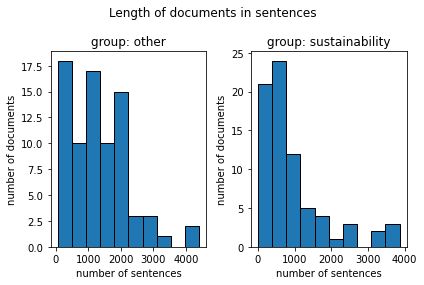

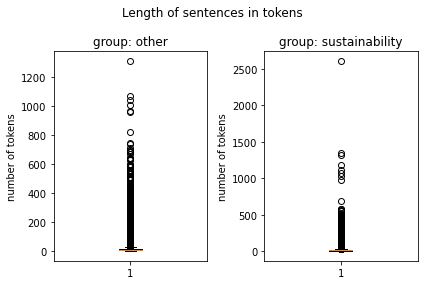

In [13]:
# length of documents and sentences
f, axes = plt.subplots(1, 2)
f.suptitle("Length of documents in sentences")
for i, group in enumerate(data.keys()):
    num_sents = [len(x['preprocessed_text']) for x in data[group]]
    axes[i].hist(num_sents, edgecolor='black')
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of sentences")
    axes[i].set_ylabel("number of documents")
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, 2)
f.suptitle("Length of sentences in tokens")
for i, group in enumerate(data.keys()):
    sent_lengths = [
        len(sent) for x in data[group] for sent in x['preprocessed_text']]
    axes[i].boxplot(sent_lengths)
    axes[i].set_title(f"group: {group}")
    axes[i].set_ylabel("number of tokens")
plt.tight_layout()
plt.show()

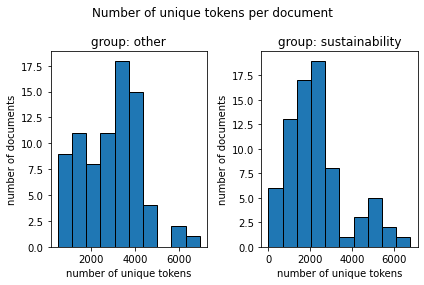

In [14]:
# size of document-wise vocabularies
f, axes = plt.subplots(1, 2)
f.suptitle("Number of unique tokens per document")

vocabulary = {}
for i, group in enumerate(data.keys()):
    group_vocabs = []
    for x in data[group]:
        tokens = [tok for sent in x['preprocessed_text'] for tok in sent]
        group_vocabs.append(Counter(tokens))
    vocabulary[group] = group_vocabs

    axes[i].hist([len(v) for v in group_vocabs], edgecolor='black')
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of unique tokens")
    axes[i].set_ylabel("number of documents")
    
plt.tight_layout()
plt.show()

Number of unique tokens in other: 36571
Number of unique tokens in sustainability: 33370


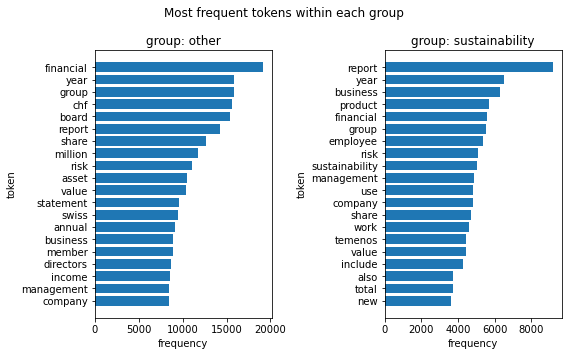

In [15]:
# current number of unique tokens in all documents
total_vocabulary = {}
for group, group_vocabs in vocabulary.items():
    total_group_vocab = Counter()
    for v in group_vocabs:
        total_group_vocab.update(v)
    total_vocabulary[group] = total_group_vocab

for group, total_group_vocab in total_vocabulary.items():
    print(f"Number of unique tokens in {group}: {len(total_group_vocab)}")

f, axes = plt.subplots(1, 2, figsize=(8, 5))
for i, group in enumerate(total_vocabulary.keys()):
    tokens, freq = zip(*total_vocabulary[group].most_common(20)[::-1])
    axes[i].barh(tokens, freq)
    
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("frequency")
    axes[i].set_ylabel("token")

f.suptitle("Most frequent tokens within each group")
plt.tight_layout()
plt.show()

In [16]:
# how many tokens appear only rarely?
min_freq = 10
for group, total_group_vocab in total_vocabulary.items():
    rare_tokens = [
        tok for tok, freq in total_group_vocab.items() if freq < min_freq
    ]

    print(f"group = {group}")
    print(f"Number of tokens with freq < {min_freq}: {len(rare_tokens)}")
    print(f"Examples: {rare_tokens[:10]}\n")

group = other
Number of tokens with freq < 10: 28114
Examples: ['stories', 'annualreportgeorgfischercom', 'andhigh', 'jointing', 'customizing', 'prefabrication', 'microelectronic', 'hycleen', 'insulate', 'prestigious']

group = sustainability
Number of tokens with freq < 10: 26587
Examples: ['porto', 'sudeste', 'deconsolidate', 'midland', 'texas', 'launder', 'ferrous', 'regrettably', 'lithium', 'ion']

